## Intro
The goal of this notebook is use different machine learning algorithms to perform binary classification for malware detection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf

from matplotlib import pyplot
from sklearn.decomposition import PCA

from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

2024-06-25 18:24:48.768019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preparation and Exploratory Data Analysis (EDA)
Using pandas, we read in the data which is separated by '|' in the CSV file

In [31]:
df = pd.read_csv('MalwareData.csv', sep='|')
df.head(10)

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1
5,airappinstaller.exe,e6e5a0ab3b1a27127c5c4a29b237d823,332,224,258,9,0,512,46592,0,...,10,4.843545,2.718577,7.965023,3858.600000,104,14671,0,16,1
6,AcroBroker.exe,dd7d901720f71e7e4f5fb13ec973d8e9,332,224,290,9,0,222720,67072,0,...,7,3.892779,1.346314,5.232167,1629.142857,52,8648,72,16,1
7,AcroRd32.exe,540c61844ccd78c121c3ef48f3a34f0e,332,224,290,9,0,823808,650240,0,...,29,4.102636,1.664392,6.373890,11939.689655,94,270376,72,15,1
8,AcroRd32Info.exe,9afe3c62668f55b8433cde602258236e,332,224,290,9,0,4096,7168,0,...,4,5.097499,3.435993,5.929812,616.500000,94,1164,72,15,1
9,AcroTextExtractor.exe,ba621a96e44f6558c08cf25b40cb1bd4,332,224,290,9,0,29696,12800,0,...,2,4.235788,3.456169,5.015407,820.000000,716,924,72,15,1


Taking a look at the data, the first two columns are 'Name' and 'md5'. We drop these two columns as "Name' is just what the file is called and a file could be called anything whether it is malware or not. 'md5' is a hash generated for file authentication and is done for every file.

In [32]:
df = df.drop(columns=['Name', 'md5'])

We check if any rows have missing data. If so, we have to deal with the missing data. However, there is no missing data in this dataset.

In [4]:
# Check for na values
df.isna().sum()

Machine                        0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeapCommit               0
LoaderFlags                    0
NumberOfRv

Looking at the dataframe, some of the columns have the same value (Machine, SizeOfOptionalHeader), so we check to see how many unique values each column has in case a column only has one value. Each column seems to have more than one unique value, so we don't remove any columns.

In [5]:
for c in df.columns:
    print(c + ": {} unique values".format(len(df[c].unique())))

Machine: 3 unique values
SizeOfOptionalHeader: 5 unique values
Characteristics: 104 unique values
MajorLinkerVersion: 41 unique values
MinorLinkerVersion: 62 unique values
SizeOfCode: 3809 unique values
SizeOfInitializedData: 3217 unique values
SizeOfUninitializedData: 441 unique values
AddressOfEntryPoint: 23110 unique values
BaseOfCode: 385 unique values
BaseOfData: 1106 unique values
ImageBase: 9099 unique values
SectionAlignment: 12 unique values
FileAlignment: 9 unique values
MajorOperatingSystemVersion: 12 unique values
MinorOperatingSystemVersion: 12 unique values
MajorImageVersion: 38 unique values
MinorImageVersion: 70 unique values
MajorSubsystemVersion: 6 unique values
MinorSubsystemVersion: 10 unique values
SizeOfImage: 2312 unique values
SizeOfHeaders: 30 unique values
CheckSum: 81633 unique values
Subsystem: 4 unique values
DllCharacteristics: 74 unique values
SizeOfStackReserve: 40 unique values
SizeOfStackCommit: 40 unique values
SizeOfHeapReserve: 30 unique values
Size

We look at how many legitimate and malware data points we have to see if there is an imbalance of each class. There is not an imbalance between legitimate (1) and malware (0) classes.

In [6]:
df['legitimate'].value_counts()

legitimate
0    96724
1    41323
Name: count, dtype: int64

Looking at the type of each column, all of them are int or float so we do not have any categorical features.

In [7]:
df.dtypes

Machine                          int64
SizeOfOptionalHeader             int64
Characteristics                  int64
MajorLinkerVersion               int64
MinorLinkerVersion               int64
SizeOfCode                       int64
SizeOfInitializedData            int64
SizeOfUninitializedData          int64
AddressOfEntryPoint              int64
BaseOfCode                       int64
BaseOfData                       int64
ImageBase                      float64
SectionAlignment                 int64
FileAlignment                    int64
MajorOperatingSystemVersion      int64
MinorOperatingSystemVersion      int64
MajorImageVersion                int64
MinorImageVersion                int64
MajorSubsystemVersion            int64
MinorSubsystemVersion            int64
SizeOfImage                      int64
SizeOfHeaders                    int64
CheckSum                         int64
Subsystem                        int64
DllCharacteristics               int64
SizeOfStackReserve       

We separate features and the target variable, convert the data to a normal distribution, and then standardize it using (data - mean) / standard deviation.

In [8]:
def zscore_normalization(df1, name):
    mean = df1[name].mean()
    sd = df1[name].std()

    df1[name] = (df1[name] - mean) / sd

X = df.drop(columns=['legitimate'])

for i in X.columns:
    X[i] = stats.boxcox(X[i], lmbda = 0.5)
    zscore_normalization(X, i)

y = df['legitimate']

We create two dataframes to record the accuracy, f1 score, and times taken to train and test the models.

In [9]:
accuracies = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
times = pd.DataFrame(columns=["Model", "Train", "Test"])

Create a function to train, test, and cross-validate each model. It cross-validates the model using K-fold validation with 5 folds. It outputs the time taken to train and test the model, the accuracy and f1 score, the confusion matrix for binary classification, and the time taken to cross-validate the model.

In [10]:
def run_model(model_type, model, X_train, X_test, y_train, y_test, X, y):
    print(model_type, "classifier:") 
    
    start_time_train = time.time()  # Start time

    model.fit(X_train, y_train)  # Fit the classifier
    
    end_time_train = time.time()  # End time
    time_taken_train = end_time_train - start_time_train  # Time taken to run the code

    print(f"Time taken to train the {model_type} model: {time_taken_train} seconds")
    
    # Make predictions
    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    time_taken_test = end_test - start_test  # Time taken to run the code

    print(f"Time taken to test the {model_type} model: {time_taken_test} seconds")
    times.loc[len(times.index)] = [model_type,time_taken_train, time_taken_test]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", recall)
    print("F1 score:", f1)

    accuracies.loc[len(accuracies.index)] = [model_type, acc, prec, recall, f1]
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    #Cross validation 
    start_time_cv = time.time() 
    
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    end_time_cv = time.time()  # End time
    time_taken_cv = end_time_cv - start_time_cv  # Time taken to run the code

    print(f"Time taken to cross-validate the {model_type} model: {time_taken_cv} seconds")
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    print("Standard deviation of CV accuracy:", cv_scores.std())

We can take a look at the correlation matrix of the data. There are several features that have high correlation with each other, which could impact our models such as logistic regression where input features should be independent of each other.

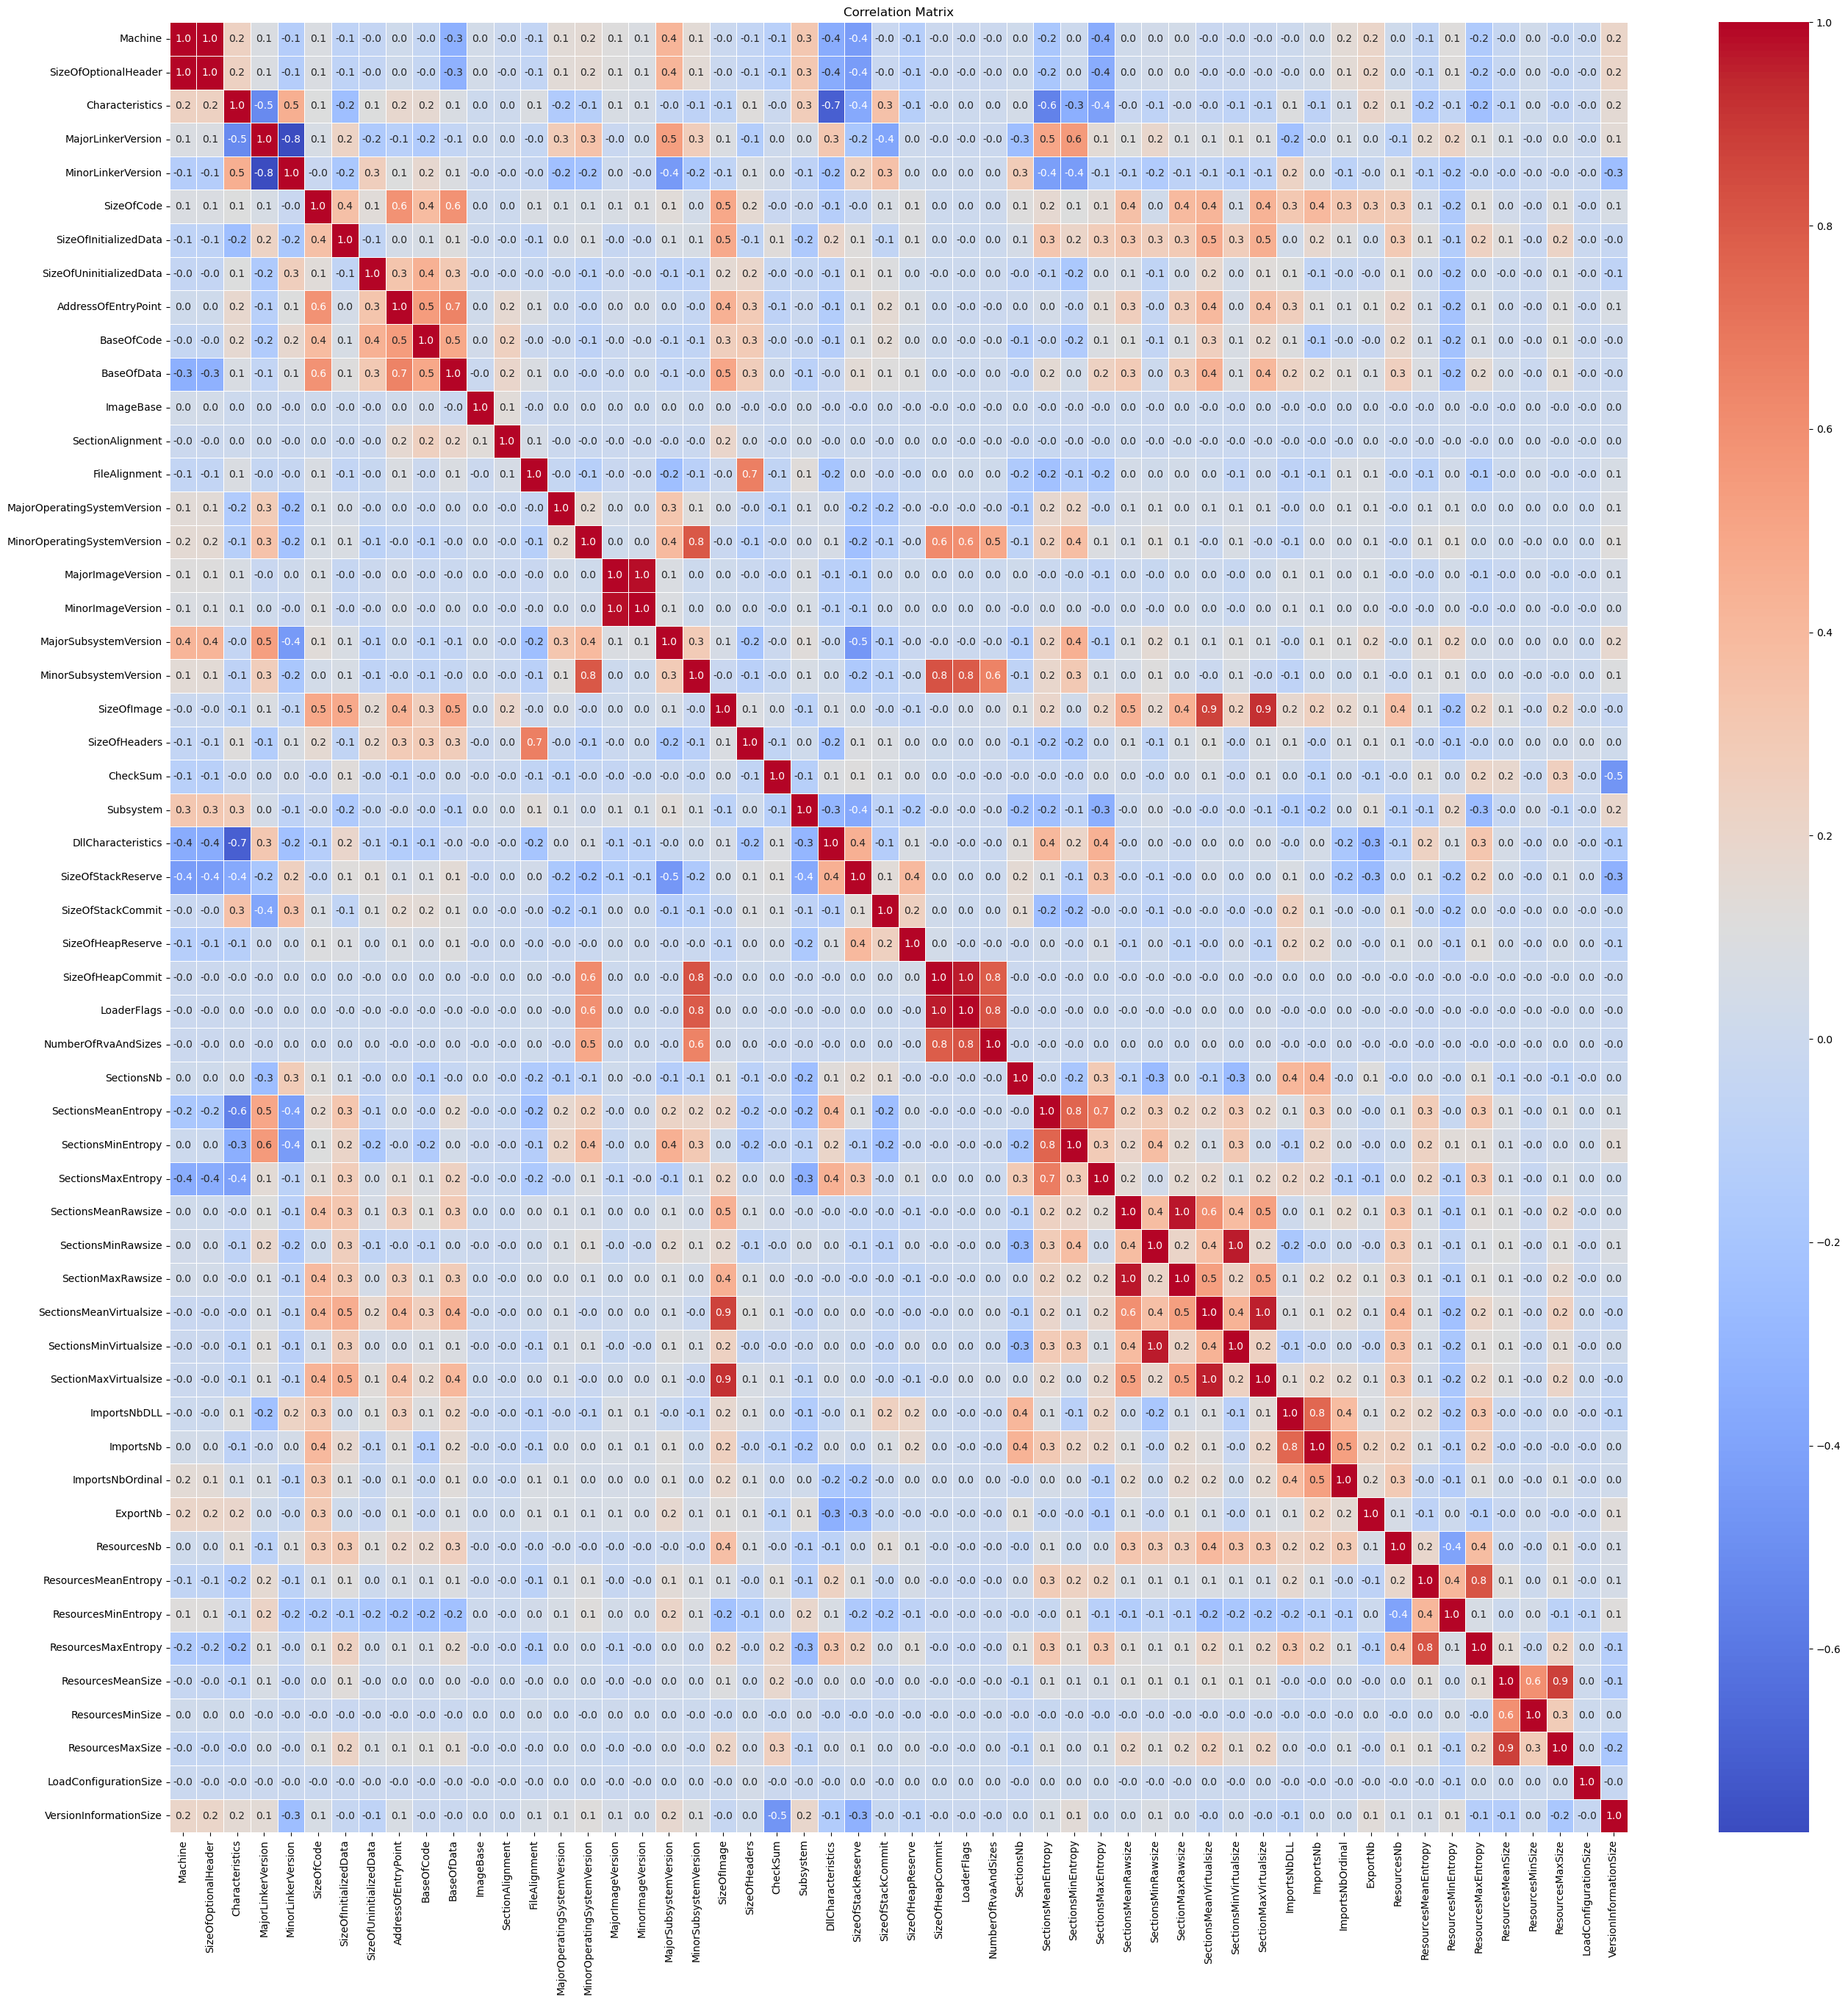

In [11]:
correlation_matrix = X.corr()
# Set up the figure size
f, ax = plt.subplots(figsize=(32, 32))
# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=.5, ax=ax, fmt='.1f')
# Set the title and show the plot
plt.title('Correlation Matrix')
plt.show()

In addition, we currently have 54 features. We choose to use Principal Component Analysis (PCA) to reduce the dimensionality of the data and obtain a smaller set of uncorrelated features. By plotting the explained variance by the first k components, we can see the minimum number of components we need to cover 96% of the variance.

35

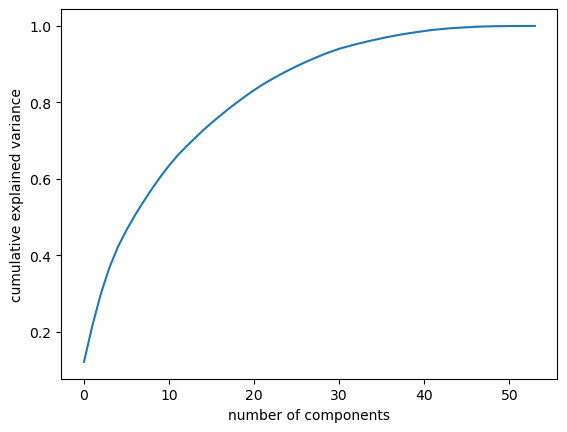

In [12]:
pca = PCA()
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.96) + 1

The number of components we should reduce our data down to is 35, so we can remove highly correlated features from our dataset.

In [13]:
cols_to_drop = []
for i in X.columns:
    for j in X.columns:
        if i != j:
            if abs(correlation_matrix[i][j]) > 0.6 and i not in cols_to_drop and j not in cols_to_drop:
                cols_to_drop.append(i)
cols_to_drop = set(cols_to_drop)
X.drop(columns=cols_to_drop, inplace=True)
print(len(cols_to_drop))

18


We then split the data into train and test data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Logistic Regression
We run, train, and cross-validate a Logistic Regression model. The model is trained quickly with an accuracy of 97.8%. From the cross-validation, the Logistic Regression model does not overfit the data since the average accuracy from cross-validation is similar to the accuracy of the model.

Logistic Regression classifier:
Time taken to train the Logistic Regression model: 0.42142271995544434 seconds
Time taken to test the Logistic Regression model: 0.005304098129272461 seconds
Accuracy: 0.9784136182542557
Precision: 0.9685297691373026
Recall: 0.9594366875300915
F1 score: 0.9639617849800459


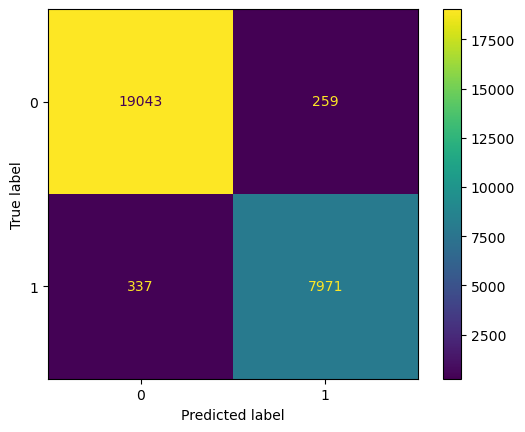

Time taken to cross-validate the Logistic Regression model: 1.8214125633239746 seconds
Cross-validation scores: [0.97464687 0.98355668 0.95762251 0.96906806 0.99003948]
Mean CV accuracy: 0.9749867202466629
Standard deviation of CV accuracy: 0.011284427647622336


In [15]:
lr_model = LogisticRegression(random_state=0, max_iter=1000)
run_model('Logistic Regression', lr_model, X_train, X_test, y_train, y_test, X, y)

## Random Forest
We run, train, and cross-validate a Random Forest model. The model took longer to train compared to the Logistic Regression model with an accuracy of 99.4%. From cross-validation, the Random Forest produces similar accuracies for each fold.

Random Forest classifier:
Time taken to train the Random Forest model: 21.321643114089966 seconds
Time taken to test the Random Forest model: 0.24775290489196777 seconds
Accuracy: 0.9941687794277436
Precision: 0.9883706989569596
Recall: 0.9922965816080885
F1 score: 0.9903297495345066


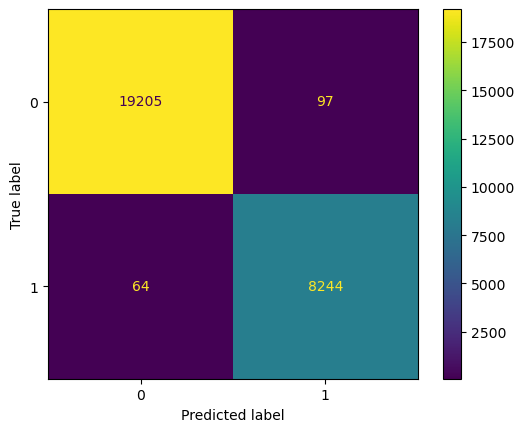

Time taken to cross-validate the Random Forest model: 96.77922892570496 seconds
Cross-validation scores: [0.99279247 0.99163347 0.96664131 0.981238   0.99706617]
Mean CV accuracy: 0.9858742842845982
Standard deviation of CV accuracy: 0.010933344680282458


In [16]:
rf = RandomForestClassifier(random_state=0)
run_model('Random Forest', rf, X_train, X_test, y_train, y_test, X, y)

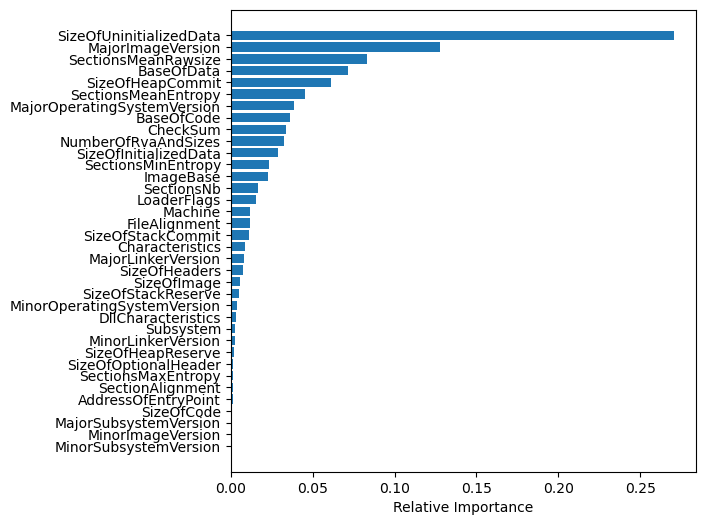

In [17]:
importances = (rf.feature_importances_)
i = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(i)), importances[i], align='center')
plt.yticks(range(len(i)), [df.columns[j] for j in i])
plt.xlabel('Relative Importance')
plt.show()

## Decision Tree
We run, train, and cross-validate a Decision Tree model. The model was faster to train compared to the Random Forest model with an accuracy of 99.2%. From cross-validation, the Decision Tree produces similar accuracies for each fold.

Decision Tree classifier:
Time taken to train the Decision Tree model: 2.106440544128418 seconds
Time taken to test the Decision Tree model: 0.00896310806274414 seconds
Accuracy: 0.9926475914523724
Precision: 0.9864362021365982
Recall: 0.9891670678863745
F1 score: 0.9877997475809844


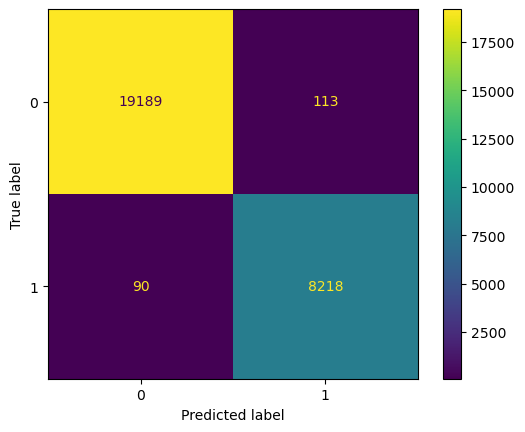

Time taken to cross-validate the Decision Tree model: 9.061930894851685 seconds
Cross-validation scores: [0.98612821 0.98703368 0.95352965 0.96580825 0.99558115]
Mean CV accuracy: 0.9776161891999141
Standard deviation of CV accuracy: 0.015514332660470913


In [18]:
dt = DecisionTreeClassifier(random_state=0)
run_model('Decision Tree', dt, X_train, X_test, y_train, y_test, X, y)

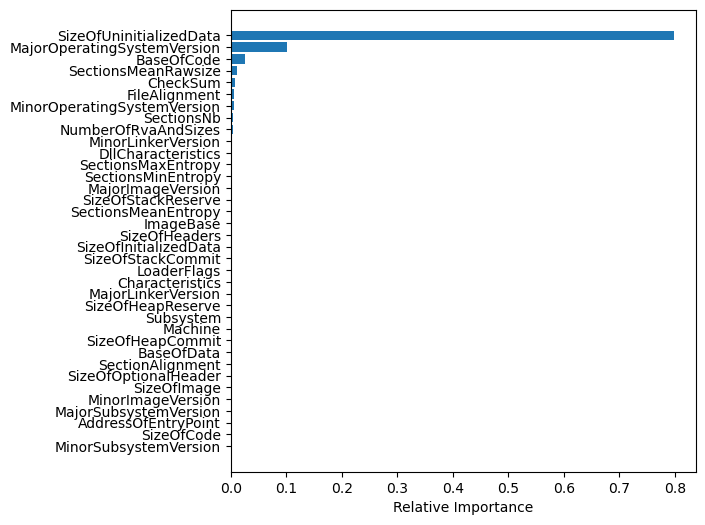

In [19]:
importances = (dt.feature_importances_)
i = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(i)), importances[i], align='center')
plt.yticks(range(len(i)), [df.columns[j] for j in i])
plt.xlabel('Relative Importance')
plt.show()

## Support Vector Machine
We run, train, and cross-validate a Support Vector Machine model. The model was significantly slower to train compared to the other models with an accuracy of 98.8%. The cross-validation took a long time to run, but produces similar accuracies for each fold.

Support Vector Machine classifier:
Time taken to train the Support Vector Machine model: 84.36225032806396 seconds
Time taken to test the Support Vector Machine model: 8.87320852279663 seconds
Accuracy: 0.9887359652299892
Precision: 0.9769772157938685
Recall: 0.9857968223399133
F1 score: 0.9813672038823318


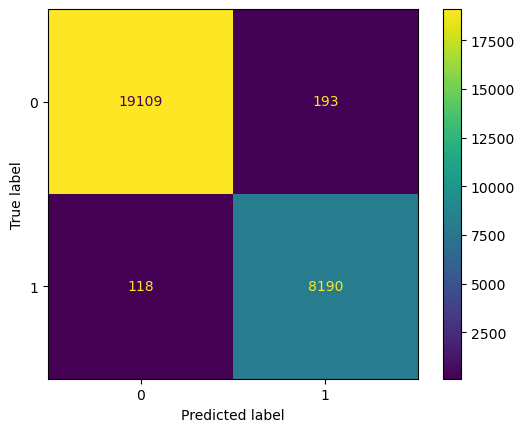

Time taken to cross-validate the Support Vector Machine model: 373.6096291542053 seconds
Cross-validation scores: [0.98616443 0.98728721 0.96062878 0.97392155 0.99286465]
Mean CV accuracy: 0.9801733242663773
Standard deviation of CV accuracy: 0.011564120097927157


In [20]:
svc_model = SVC(random_state=0)
run_model('Support Vector Machine', svc_model, X_train, X_test, y_train, y_test, X, y)

## Gradient Boost
We run, train, and cross-validate a Gradient Boost model. The model was slower to train compared to the other models except SVM with an accuracy of 99.0%. 

Gradient Boost classifier:
Time taken to train the Gradient Boost model: 35.56341624259949 seconds
Time taken to test the Gradient Boost model: 0.04242372512817383 seconds
Accuracy: 0.9902933719666788
Precision: 0.9823614110871131
Recall: 0.9854357246027925
F1 score: 0.9838961663261627


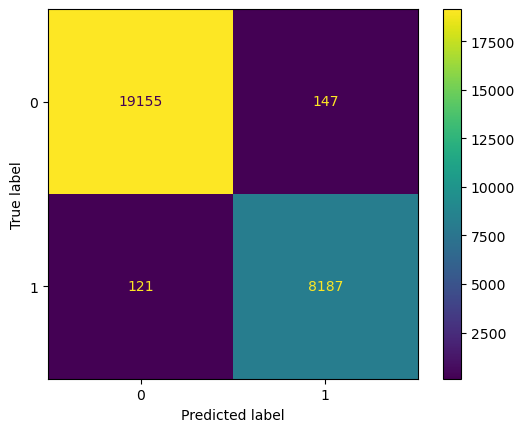

Time taken to cross-validate the Gradient Boost model: 172.11827683448792 seconds
Cross-validation scores: [0.98913437 0.98728721 0.98373719 0.97910102 0.99478431]
Mean CV accuracy: 0.986808820155845
Standard deviation of CV accuracy: 0.005255294994460859


In [21]:
gbc = GradientBoostingClassifier()
run_model('Gradient Boost', gbc, X_train, X_test, y_train, y_test, X, y)

## Gaussian Naive Bayes
We run, train, and cross-validate a Gaussian Naive Bayes model. By converting the data into a normal distribution, we were able to use the Gaussian Naive Bayes as it assumes that our data follows a normal distribution. The model was quick to train with an accuracy of 94.4%. 

Gaussian Naive Bayes classifier:
Time taken to train the Gaussian Naive Bayes model: 0.09730219841003418 seconds
Time taken to test the Gaussian Naive Bayes model: 0.013509750366210938 seconds
Accuracy: 0.9444766388989496
Precision: 0.8476141611082606
Recall: 0.9942224362060664
F1 score: 0.9150833656455991


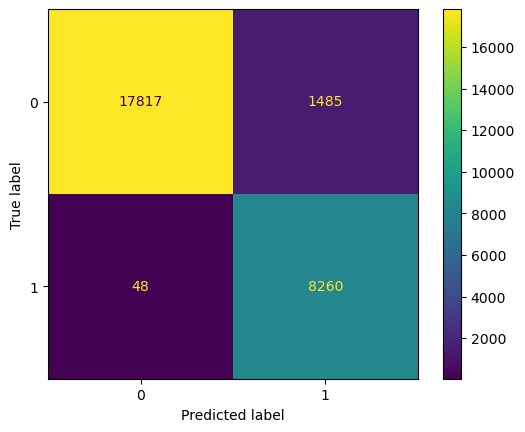

Time taken to cross-validate the Gaussian Naive Bayes model: 0.711198091506958 seconds
Cross-validation scores: [0.9496197  0.57153205 0.9599406  0.94726357 0.94418487]
Mean CV accuracy: 0.874508159283157
Standard deviation of CV accuracy: 0.1515804474925246


In [22]:
gnb = GaussianNB()
run_model('Gaussian Naive Bayes', gnb, X_train, X_test, y_train, y_test, X, y)

## Artificial Neural Network
We build an Artificial Neural Network with 1 input layer, 1 hidden layer with 64 units, and 1 output layer. We chose the 'relu' activation function for the hidden layers and use the adam optimizter and mean absolute error loss. We then train the model using batch size of 256 and 60 epochs. By implementing the early stopping optimization method, the model training will be stopped automatically when the model begins to overfit the data which is when the validation loss begins to increase. This happens at about 54 epochs, taking 73.9 seconds, which is shorter than the time it took the Random Forest model and SVM model to train.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2368      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/60
432/432 [==============================] - 2s 4ms/step - loss: 0.0742 - accuracy: 0.9706 - val_loss: 0.0457 - val_accuracy: 0.9817
Epoch 2/60
432/432 [==============================] - 2s 3ms/step - loss: 0.0403 - accuracy: 0.9838 - val_loss: 0.0369 - val_accuracy: 0.9837
Epoch 3/60
432/432 [==============================] - 2s 4ms/step - loss: 0.0349 - accuracy: 0.9848 - val_loss: 0.0344 - val_accuracy: 0.9843
Epoch 4/60
432/432 [==============================] - 1s 3ms/step - loss: 0.0326 - accuracy: 0.9854 - val_loss: 0.0353 - val_accuracy: 0.9852
Epoch 5/60
432/432 [==============================] - 1s 3ms/step - loss: 0.0306 - accuracy: 0.9858 - val_loss: 0.0315 - val_accuracy: 0.9856
Epoch 6/60
432/432 [==============================] - 1s 3ms/step - loss: 0.0292 - accuracy: 0.9863 - val_loss: 0.0289 - val_accuracy: 0.9857
Epoch 7/60
432/432 [==============================] - 1s 3ms/step - loss: 0.0277 - accuracy: 0.9866 - val_loss: 0.0296 - val_accuracy: 0.9859
E

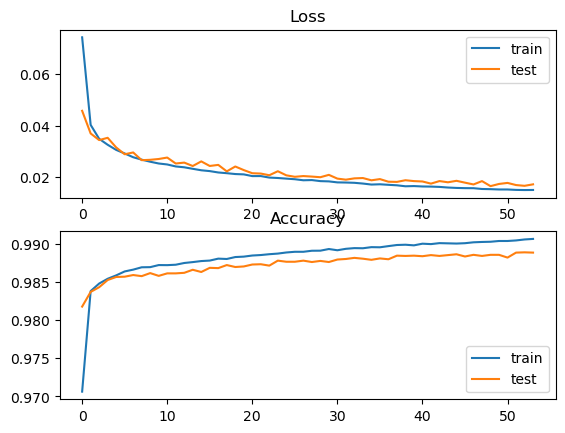

In [34]:
from keras import callbacks
input_shape = [X_train.shape[1]]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.build()

print(model.summary())
start_time_train = time.time()  # Start time

model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])  
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=256, epochs=60,callbacks=[earlystopping])
    
end_time_train = time.time()  # End time
time_taken_train = end_time_train - start_time_train  # Time taken to run the code

print(f"Time taken to train the Artificial Neural Network: {time_taken_train} seconds")
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
accuracy = history.history['accuracy'][11]

accuracies.loc[len(accuracies.index)] = ['ANN', accuracy, 0, 0, 0]
times.loc[len(times.index)] = ['ANN',time_taken_train, time_taken_train]

<Axes: xlabel='Model'>

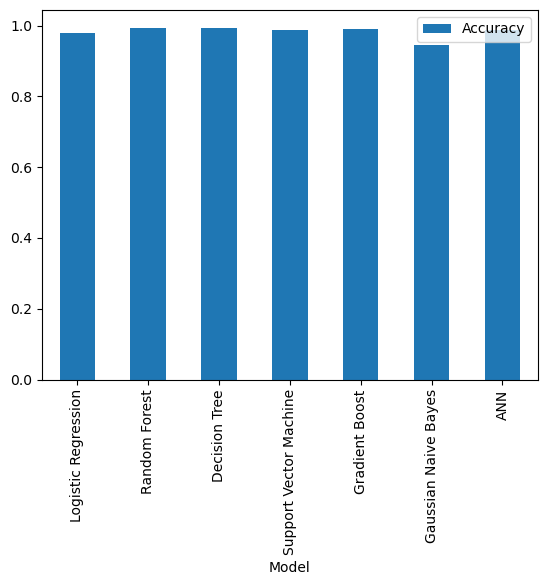

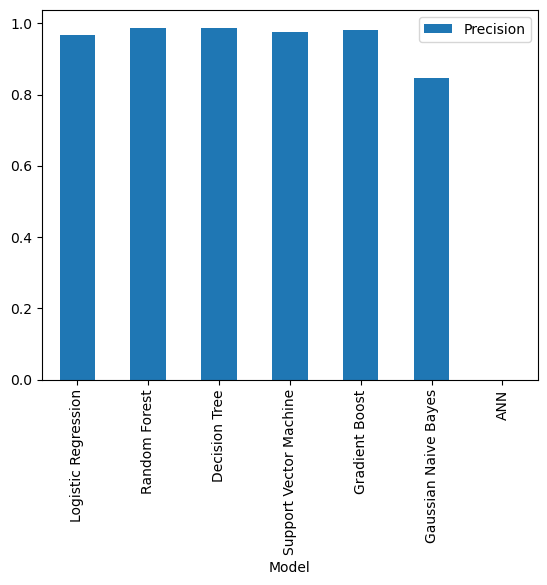

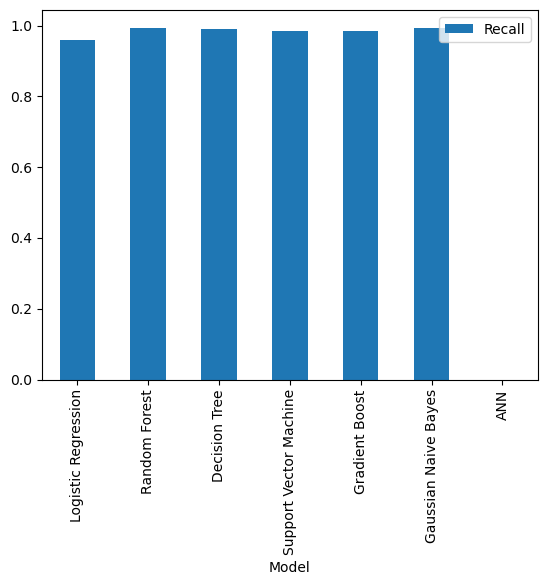

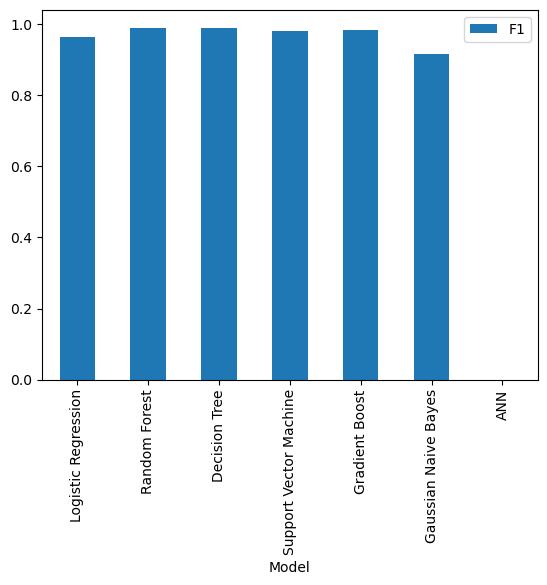

In [36]:
accuracies.plot(kind='bar', x='Model', y='Accuracy')
accuracies.plot(kind='bar', x='Model', y='Precision')
accuracies.plot(kind='bar', x='Model', y='Recall')
accuracies.plot(kind='bar', x='Model', y='F1')

In [37]:
print(times)

                    Model      Train       Test
0     Logistic Regression   0.421423   0.005304
1           Random Forest  21.321643   0.247753
2           Decision Tree   2.106441   0.008963
3  Support Vector Machine  84.362250   8.873209
4          Gradient Boost  35.563416   0.042424
5    Gaussian Naive Bayes   0.097302   0.013510
6                     ANN  73.928875  73.928875


In [39]:
print(accuracies)

                    Model  Accuracy  Precision    Recall        F1
0     Logistic Regression  0.978414   0.968530  0.959437  0.963962
1           Random Forest  0.994169   0.988371  0.992297  0.990330
2           Decision Tree  0.992648   0.986436  0.989167  0.987800
3  Support Vector Machine  0.988736   0.976977  0.985797  0.981367
4          Gradient Boost  0.990293   0.982361  0.985436  0.983896
5    Gaussian Naive Bayes  0.944477   0.847614  0.994222  0.915083
6                     ANN  0.987224   0.000000  0.000000  0.000000
